In [1]:
import torch
import torch.nn as nn
import numpy as np

import datasets.datasets as dtset
import utils.losses as losses

from utils.weakener import Weakener

from models.model import MLP

from utils.trainig_testing import train_and_evaluate

### Loading of the data
At first, Data has some important atibutes that will be expanded with the weakening process.
The essential one in order to call the weakening process is the number of classes. 
- Data.num_classes: c
- Data.train_dataset: Torch dataset (X,y)
    + X can be accesed with Data.train_dataset.data (N_train , Data.num_features)
    + y (one-hot encoded) can be accesed with Data.train_dataset.targets (N_train , Data.num_classes)


In [2]:
# GesturePhaseSegmentationProcessed (6911, 5)
#Data = dtset.OpenML_Dataset('GesturePhaseSegmentationProcessed', batch_size = 16)
Data = dtset.Torch_Dataset('mnist', batch_size = 16)

100%|██████████| 9912422/9912422 [00:00<00:00, 11496321.58it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 12607425.29it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw


100%|██████████| 4542/4542 [00:00<00:00, 4553185.65it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



### Creating the Weakening process
Once our data is loaded we can create the Weakening process.
For creating the mixing matrix, ${\bf M}$, is essential to know the number of classes the problem has

After that, we ask for the corruption type we want to generate over our dataset

In [3]:
Weak = Weakener(Data.num_classes)
Weak.generate_M(model_class='pll')

Once our ${\bf M}$ matrix is created we can print the methods and attributes for each class so we can know what are they capable of.

In [4]:
print('Methods for Data Class','\n',[method for method in dir(Data) if (method[0] != '_') & callable(getattr(Data, method)) ],'\n'
      'Instances for Data Class','\n',[method for method in dir(Data) if (method[0] != '_') & (method not in [method for method in dir(Data) if (method[0] != '_') & callable(getattr(Data, method)) ]) ],'\n\n'
      'Methods for Weak Class','\n',[method for method in dir(Weak) if (method[0] != '_') & callable(getattr(Weak, method)) ],'\n'
      'Instances for Weak Class','\n',[method for method in dir(Weak) if (method[0] != '_') & (method not in [method for method in dir(Weak) if (method[0] != '_') & callable(getattr(Weak, method)) ]) ])

Methods for Data Class 
 ['get_data', 'get_dataloader', 'include_weak', 'transform'] 
Instances for Data Class 
 ['batch_size', 'dataset', 'num_classes', 'num_features', 'shuffle', 'test_dataset', 'test_num_samples', 'train_dataset', 'train_num_samples', 'weak_labels'] 

Methods for Weak Class 
 ['generate_M', 'generate_weak', 'generate_wl_priors', 'label_matrix', 'pll_weights', 'virtual_labels', 'virtual_matrix'] 
Instances for Weak Class 
 ['M', 'Z', 'c', 'd', 'labels', 'pll_p', 'w', 'z']


There are two matrices and a dictionary encoding or weakening process:
- Weak.M: The mixing matrix
- Weak.Z: The one hot encoding matrix (reades by rows)
- Weak.labels: A dictionary summarizing Weak.Z

In [5]:
Weak.generate_M('pll',pll_p=0.5)
Weak.M[:5,:],Weak.Z[:5,:],Weak.labels

(array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.00195312],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.00195312, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.00195312, 0.00195312],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.00195312, 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.00195312, 0.        , 0.00195312]]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 1]]),
 {0: '0000000001',
  1: '0000000010',
  2: '0000000011',
  3: '0000000100',
  4: '0000000101',
  5: '

In [6]:
train_X,train_y,test_X,test_y =  Data.get_data()
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

torch.Size([60000, 784])
torch.Size([60000, 10])
torch.Size([10000, 784])
torch.Size([10000, 10])


Now we will create the weak labels for the training set. After this the classifier should only take those when training.
It will create two attributes within the Weak class
- Weak.z the identifier of the weak label
- Weak.w the indicator array of the classes belonging to the subset for thar weak label.

:warning: This operation should be done only once as it resamples the labels from ${\bf M}$

In [7]:
Weak.generate_weak(train_y)

(tensor([ 48, 628, 568,  ..., 247, 990, 446], dtype=torch.int32),
 tensor([[0., 0., 0.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 1., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 1.],
         ...,
         [0., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [0., 1., 1.,  ..., 1., 1., 1.]], dtype=torch.float64))

Now we need to include this weak labels into the dataset.

The thing is that we need to include the virtual labels

In [8]:
Weak.virtual_labels()

C:\Users\danibacaicoa\AppData\Roaming\Python\Python311\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


In [9]:
Weak.z

tensor([ 48, 628, 568,  ..., 247, 990, 446], dtype=torch.int32)

In [10]:
Data.include_weak(Weak.z)

And finally we create a dataloader structure so we can start the optimization in PyTorch

In [11]:
trainloader,testloader = Data.get_dataloader()

In [12]:
examples = next(iter(trainloader))
for k in examples:
    print(k.shape)


torch.Size([16, 784])
torch.Size([16])
torch.Size([16, 10])
torch.Size([16])


In [13]:
print('Methods for MLP Class','\n',[method for method in dir(MLP) if (method[0] != '_') & callable(getattr(MLP, method)) ],'\n'
      'Instances for MLP Class','\n',[method for method in dir(MLP) if (method[0] != '_') & (method not in [method for method in dir(MLP) if (method[0] != '_') & callable(getattr(MLP, method))])])

Methods for MLP Class 
 ['add_module', 'apply', 'bfloat16', 'buffers', 'children', 'compile', 'cpu', 'cuda', 'double', 'eval', 'extra_repr', 'float', 'forward', 'get_buffer', 'get_extra_state', 'get_parameter', 'get_submodule', 'half', 'ipu', 'load_state_dict', 'modules', 'named_buffers', 'named_children', 'named_modules', 'named_parameters', 'parameters', 'register_backward_hook', 'register_buffer', 'register_forward_hook', 'register_forward_pre_hook', 'register_full_backward_hook', 'register_full_backward_pre_hook', 'register_load_state_dict_post_hook', 'register_module', 'register_parameter', 'register_state_dict_pre_hook', 'requires_grad_', 'set_extra_state', 'share_memory', 'state_dict', 'to', 'to_empty', 'train', 'type', 'xpu', 'zero_grad'] 
Instances for MLP Class 
 ['T_destination', 'call_super_init', 'dump_patches']


In [16]:
loss = losses.EMLoss(Weak.M)
overall_results = {}
overall_models = {}
for i in range(10):
    mlp = MLP(Data.num_features,[Data.num_features],Data.num_classes, dropout_p=0.5, bn=True, activation =  'gelu')
    optim = torch.optim.Adam(mlp.parameters(),lr=1e-2)
    mlp, results = train_and_evaluate(mlp,trainloader,testloader,optimizer=optim,loss_fn=loss,num_epochs=50,sound=10)
    overall_results[i] = results
    overall_models[i] = mlp    

Epoch 10/50: Train Loss: 0.2214, Train Acc: 0.9140, Test Acc: 0.9701
Epoch 20/50: Train Loss: 0.1780, Train Acc: 0.9267, Test Acc: 0.9678
Epoch 30/50: Train Loss: 0.1577, Train Acc: 0.9348, Test Acc: 0.9726
Epoch 40/50: Train Loss: 0.1406, Train Acc: 0.9394, Test Acc: 0.9749
Epoch 50/50: Train Loss: 0.1400, Train Acc: 0.9425, Test Acc: 0.9741
Epoch 10/50: Train Loss: 0.2214, Train Acc: 0.9125, Test Acc: 0.9682
Epoch 20/50: Train Loss: 0.1807, Train Acc: 0.9270, Test Acc: 0.9722
Epoch 30/50: Train Loss: 0.1576, Train Acc: 0.9344, Test Acc: 0.9710
Epoch 40/50: Train Loss: 0.1545, Train Acc: 0.9363, Test Acc: 0.9730
Epoch 50/50: Train Loss: 0.1373, Train Acc: 0.9419, Test Acc: 0.9730
Epoch 10/50: Train Loss: 0.2167, Train Acc: 0.9170, Test Acc: 0.9626
Epoch 20/50: Train Loss: 0.1782, Train Acc: 0.9280, Test Acc: 0.9695
Epoch 30/50: Train Loss: 0.1551, Train Acc: 0.9357, Test Acc: 0.9696
Epoch 40/50: Train Loss: 0.1509, Train Acc: 0.9382, Test Acc: 0.9711
Epoch 50/50: Train Loss: 0.1475, T

KeyboardInterrupt: 

In [21]:
import pickle
Results_mnist_em = [overall_results,overall_models]
f = open("results/Results_mnist_em.pkl","wb")
pickle.dump(Results_mnist_em,f)
f.close()

#Results_mnist_ce = pickle.load( open ("results/Results_mnist_em.pkl", "rb") )

Now we create our model

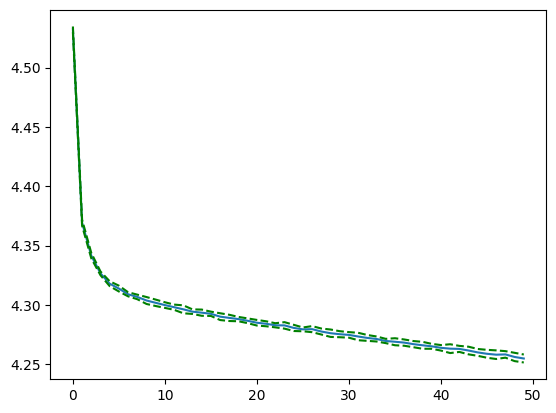

In [15]:
import matplotlib.pyplot as plt

tr_loss = np.array(overall_results[0]['train_loss'])
tr_acc = np.array(overall_results[0]['train_acc'])
te_acc = np.array(overall_results[0]['test_acc'])
for i in range(9):
    tr_loss = np.vstack((tr_loss,overall_results[i+1]['train_loss']))
    tr_acc = np.vstack((tr_acc,overall_results[i+1]['train_acc']))
    te_acc = np.vstack((te_acc,overall_results[i+1]['test_acc']))
plt.plot(np.mean(tr_loss,0))
plt.plot(np.mean(tr_loss,0)+np.std(tr_loss,0),'g--')
plt.plot(np.mean(tr_loss,0)-np.std(tr_loss,0),'g--')

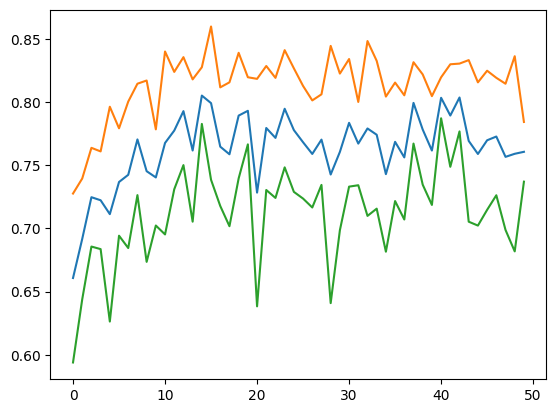

In [16]:
plt.plot(np.mean(te_acc,0))
plt.plot(np.mean(te_acc,0)+np.std(te_acc,0))
plt.plot(np.mean(te_acc,0)-np.std(te_acc,0))

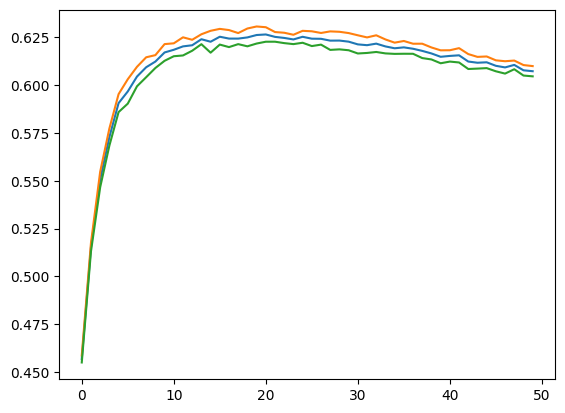

In [17]:
plt.plot(np.mean(tr_acc,0))
plt.plot(np.mean(tr_acc,0)+np.std(tr_acc,0))
plt.plot(np.mean(tr_acc,0)-np.std(tr_acc,0))

In [18]:
np.std(tr_loss,0)

array([0.00238794, 0.00256342, 0.0022581 , 0.00156742, 0.00204915,
       0.00244589, 0.00172797, 0.00192363, 0.00291979, 0.00270625,
       0.00237743, 0.00219965, 0.00334734, 0.00191625, 0.00261209,
       0.00181534, 0.00286247, 0.00263008, 0.0018273 , 0.00200041,
       0.00236739, 0.00209891, 0.00174617, 0.00272751, 0.00261115,
       0.00159575, 0.00256011, 0.00251838, 0.00311929, 0.00253986,
       0.00234831, 0.00313705, 0.00246534, 0.00211554, 0.00180114,
       0.0029587 , 0.00264333, 0.00260027, 0.00291715, 0.00206534,
       0.00232508, 0.00371117, 0.00255209, 0.00321938, 0.00288048,
       0.00333817, 0.00362765, 0.00274923, 0.00349953, 0.00335445],
      dtype=float32)

In [19]:
(np.vstack((mean_res,overall_results[1]['train_loss']))).shape

NameError: name 'mean_res' is not defined

In [ ]:
mlp = MLP(Data.num_features,[Data.num_features],Data.num_classes, dropout_p=0.5, bn=True, activation =  'gelu')

In [ ]:
#optim= torch.optim.SGD(mlp.parameters(), lr=0.01, momentum=0.9)
optim = torch.optim.Adam(mlp.parameters(),lr=1e-2)
loss = losses.CELoss()

In [ ]:
mlp, results = train_and_evaluate(mlp,trainloader,testloader,optimizer=optim,loss_fn=loss,num_epochs=10,sound=1)

c:\Users\danibacaicoa\vscode_projects\Learning_from_weak_labels\.venv\lib\site-packages\torch\autograd\__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ..\c10\cuda\CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


KeyboardInterrupt: 

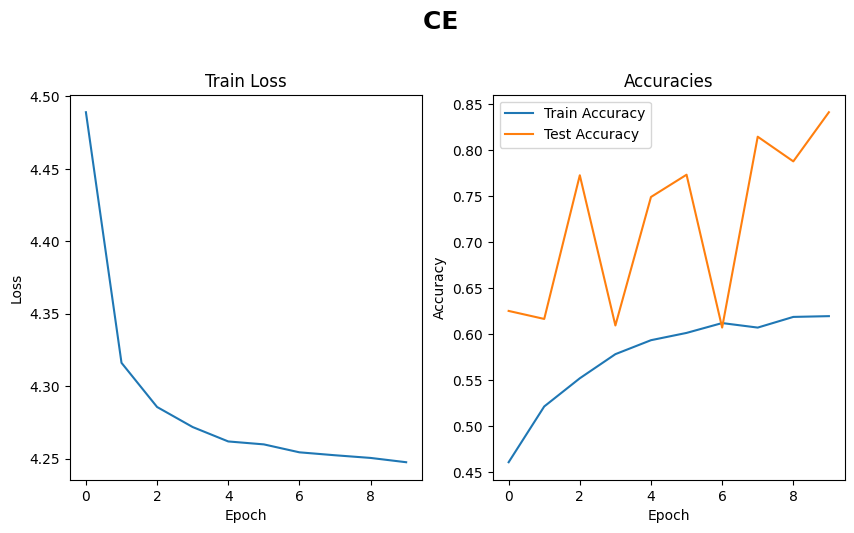

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first subplot (Train Loss)
ax1.plot(results['train_loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Train Loss')

# Plot the second subplot (Accuracies)
ax2.plot(results['train_acc'], label='Train Accuracy')
ax2.plot(results['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracies')
ax2.legend()

fig.suptitle('CE ', fontsize=18, fontweight='bold', y=1.05)
# Show the plot
plt.show()